Na początek zaimportujmy wszystkie potrzebne bibliteki klasy oraz funkcje:

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, \
  ConfusionMatrixDisplay, classification_report, RocCurveDisplay, \
  f1_score, recall_score, precision_score
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

# Wczytanie danych

Korzystamy ze zbioru weather.csv, który zawiera dane pogodowe z 366 dni, odnotowane w mieście Canberra, w Australii.

Wczytajmy go teraz za pomocą funkcji `read_csv` z biblioteki pandas, która zwróci nam obiekt `DataFrame` i sprawdzimy jak on wygląda:

In [83]:
data = pd.read_csv("weather.csv")
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,29,1019.7,1015.0,7,7,14.4,23.6,No,3.6,Yes
1,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,36,1012.4,1008.4,5,3,17.5,25.7,Yes,3.6,Yes
2,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,69,1009.5,1007.2,8,7,15.4,20.2,Yes,39.8,Yes
3,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,56,1005.5,1007.0,2,7,13.5,14.1,Yes,2.8,Yes
4,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,49,1018.3,1018.5,7,7,11.1,15.4,Yes,0.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2008-10-27,Canberra,9.0,30.7,0.0,7.6,12.1,NNW,76.0,SSE,...,15,1016.1,1010.8,1,3,20.4,30.0,No,0.0,No
362,2008-10-28,Canberra,7.1,28.4,0.0,11.6,12.7,N,48.0,NNW,...,22,1020.0,1016.9,0,1,17.2,28.2,No,0.0,No
363,2008-10-29,Canberra,12.5,19.9,0.0,8.4,5.3,ESE,43.0,ENE,...,47,1024.0,1022.8,3,2,14.5,18.3,No,0.0,No
364,2008-10-30,Canberra,12.5,26.9,0.0,5.0,7.1,NW,46.0,SSW,...,39,1021.0,1016.2,6,7,15.8,25.9,No,0.0,No


Widzimy że zbiór posiada 366 rekordów po 24 kolumn każdy. Sprawdźmy jeszcze jak przedstawiają się konkretne kolumny:

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           366 non-null    object 
 1   Location       366 non-null    object 
 2   MinTemp        366 non-null    float64
 3   MaxTemp        366 non-null    float64
 4   Rainfall       366 non-null    float64
 5   Evaporation    366 non-null    float64
 6   Sunshine       363 non-null    float64
 7   WindGustDir    363 non-null    object 
 8   WindGustSpeed  364 non-null    float64
 9   WindDir9am     335 non-null    object 
 10  WindDir3pm     365 non-null    object 
 11  WindSpeed9am   359 non-null    float64
 12  WindSpeed3pm   366 non-null    int64  
 13  Humidity9am    366 non-null    int64  
 14  Humidity3pm    366 non-null    int64  
 15  Pressure9am    366 non-null    float64
 16  Pressure3pm    366 non-null    float64
 17  Cloud9am       366 non-null    int64  
 18  Cloud3pm  

Od razu widzimy, że niektóre z kolumn zawierają wartości `NaN`. Zajmiemy się tym niedługo. Oprócz tego widzimy, że 12 kolumn jest typu `float`, 5 typu `int`, oraz 7 typu `object`.

# Analiza danych
### Usuwanie niepotrzebnych wartości w zbiorze
Na pierwszy rzut oka widzimy, że nasz zbiór danych zawiera w sobie kolumny, które nie będą istotne w procesie uczenia, bądź wręcz będą w nim przeszkadzać. Właśnie dlatego zaczniemy od ich usunięcia:

- Lokalizacja
- Czy padało dzisiaj?
- Ryzyko deszczu
- Data

In [85]:
df = data.drop(columns=["Date","Location","RainToday","RISK_MM"])
df

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
0,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,6.0,20,68,29,1019.7,1015.0,7,7,14.4,23.6,Yes
1,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,4.0,17,80,36,1012.4,1008.4,5,3,17.5,25.7,Yes
2,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,6.0,6,82,69,1009.5,1007.2,8,7,15.4,20.2,Yes
3,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,W,30.0,24,62,56,1005.5,1007.0,2,7,13.5,14.1,Yes
4,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,ESE,20.0,28,68,49,1018.3,1018.5,7,7,11.1,15.4,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,9.0,30.7,0.0,7.6,12.1,NNW,76.0,SSE,NW,7.0,50,38,15,1016.1,1010.8,1,3,20.4,30.0,No
362,7.1,28.4,0.0,11.6,12.7,N,48.0,NNW,NNW,2.0,19,45,22,1020.0,1016.9,0,1,17.2,28.2,No
363,12.5,19.9,0.0,8.4,5.3,ESE,43.0,ENE,ENE,11.0,9,63,47,1024.0,1022.8,3,2,14.5,18.3,No
364,12.5,26.9,0.0,5.0,7.1,NW,46.0,SSW,WNW,6.0,28,69,39,1021.0,1016.2,6,7,15.8,25.9,No


Oprócz tego, sporządźmy macierz korelacji, aby sprawdzić, czy są jeszcze kolumny, które można usunąć:

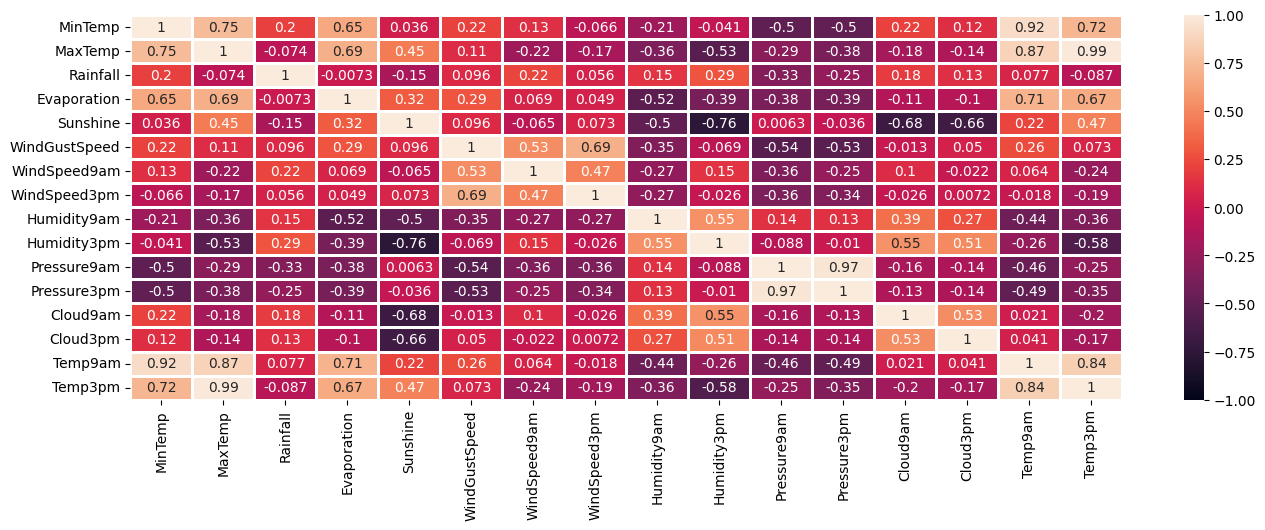

In [86]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize = (16,5))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True,linewidths=1)
plt.show()

Widać bardzo silną korelację na poziomie > 0.9 pomiędzy kolumnami Temp9am <-> MinTemp, Temp5pm <-> MaxTemp oraz Presssure9am <-> Pressure3pm. Usuńmy w takim razie po jednej z każdej pary:

In [87]:
df = df.drop(columns=['Temp3pm','Temp9am','Pressure9am'])
df

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainTomorrow
0,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,6.0,20,68,29,1015.0,7,7,Yes
1,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,4.0,17,80,36,1008.4,5,3,Yes
2,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,6.0,6,82,69,1007.2,8,7,Yes
3,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,W,30.0,24,62,56,1007.0,2,7,Yes
4,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,ESE,20.0,28,68,49,1018.5,7,7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,9.0,30.7,0.0,7.6,12.1,NNW,76.0,SSE,NW,7.0,50,38,15,1010.8,1,3,No
362,7.1,28.4,0.0,11.6,12.7,N,48.0,NNW,NNW,2.0,19,45,22,1016.9,0,1,No
363,12.5,19.9,0.0,8.4,5.3,ESE,43.0,ENE,ENE,11.0,9,63,47,1022.8,3,2,No
364,12.5,26.9,0.0,5.0,7.1,NW,46.0,SSW,WNW,6.0,28,69,39,1016.2,6,7,No


## Przegląd danych

Na początek zobaczmy, co możemy powiedzieć o naszych zmiennych kategorycznych:

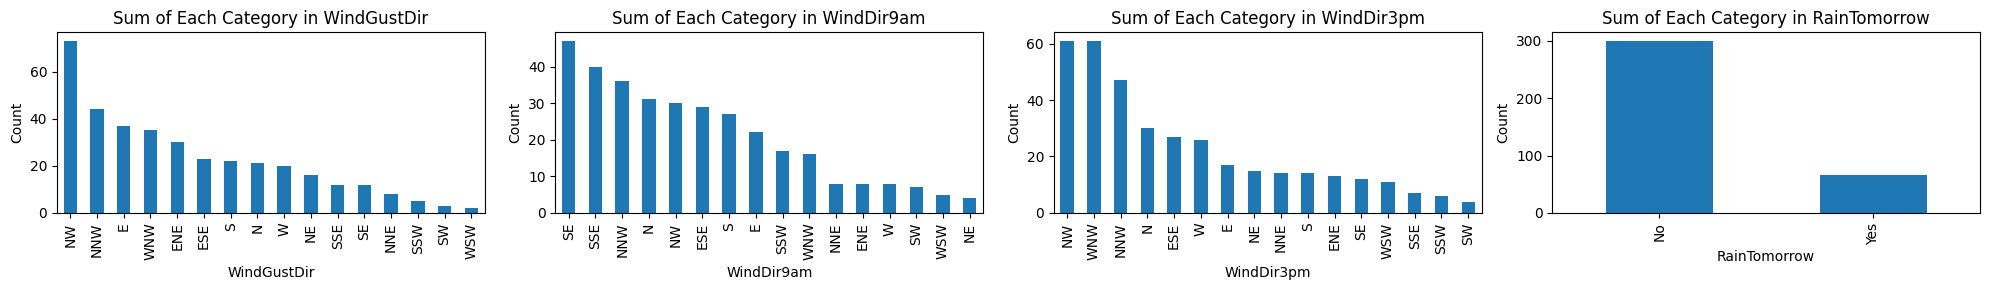

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 3))

axes = axes.flatten()
columns = ['WindGustDir','WindDir9am','WindDir3pm','RainTomorrow']
for i,column in enumerate(columns):
  ax = axes[i]
  category_counts = df[column].value_counts()
  category_counts.plot(kind='bar', ax=ax)
  ax.set_title(f'Sum of Each Category in {column}')
  ax.set_xlabel(column)
  ax.set_ylabel('Count')


plt.tight_layout()

plt.show()

Widzimy następujące własności:
- Najsilniejszy wiatr w przeciągu dnia najczęściej wieje od strony północnego - zachodu.
- Podobnie sytuacja się ma z wiatrem popołudniowym.
- W przypadku wiatru porannego, widzimy raczej odwrotny trend, ponieważ wieje on najczęściej ze strony południowego - wschodu.

Co do naszej zmiennej celu widzimy, że znaczącą większość stanowią dni, w których deszcz nie padał, może to źle wpłynąć na proces uczenia się. Aby uniknąć błędnej ewaluacji naszych modeli, zastosujemy dwie możliwości:
- Spojrzenie na metrykę wyniku f1, która dobrze sprawdza się własnie w takich przypadkach.
- Sztuczne wyrównanie naszego zbioru.

Klasyfikację postanowiłem podzielić na dwie oddzielne sekcje, gdzie pierwsza nie będzie korzystała z wyrówywania zbioru, a spojrzymy jedynie na metryki - w szczególności wynik f1, a druga zbiór wyrówna.

Przyjrzyjmy się teraz zmiennym numerycznym:

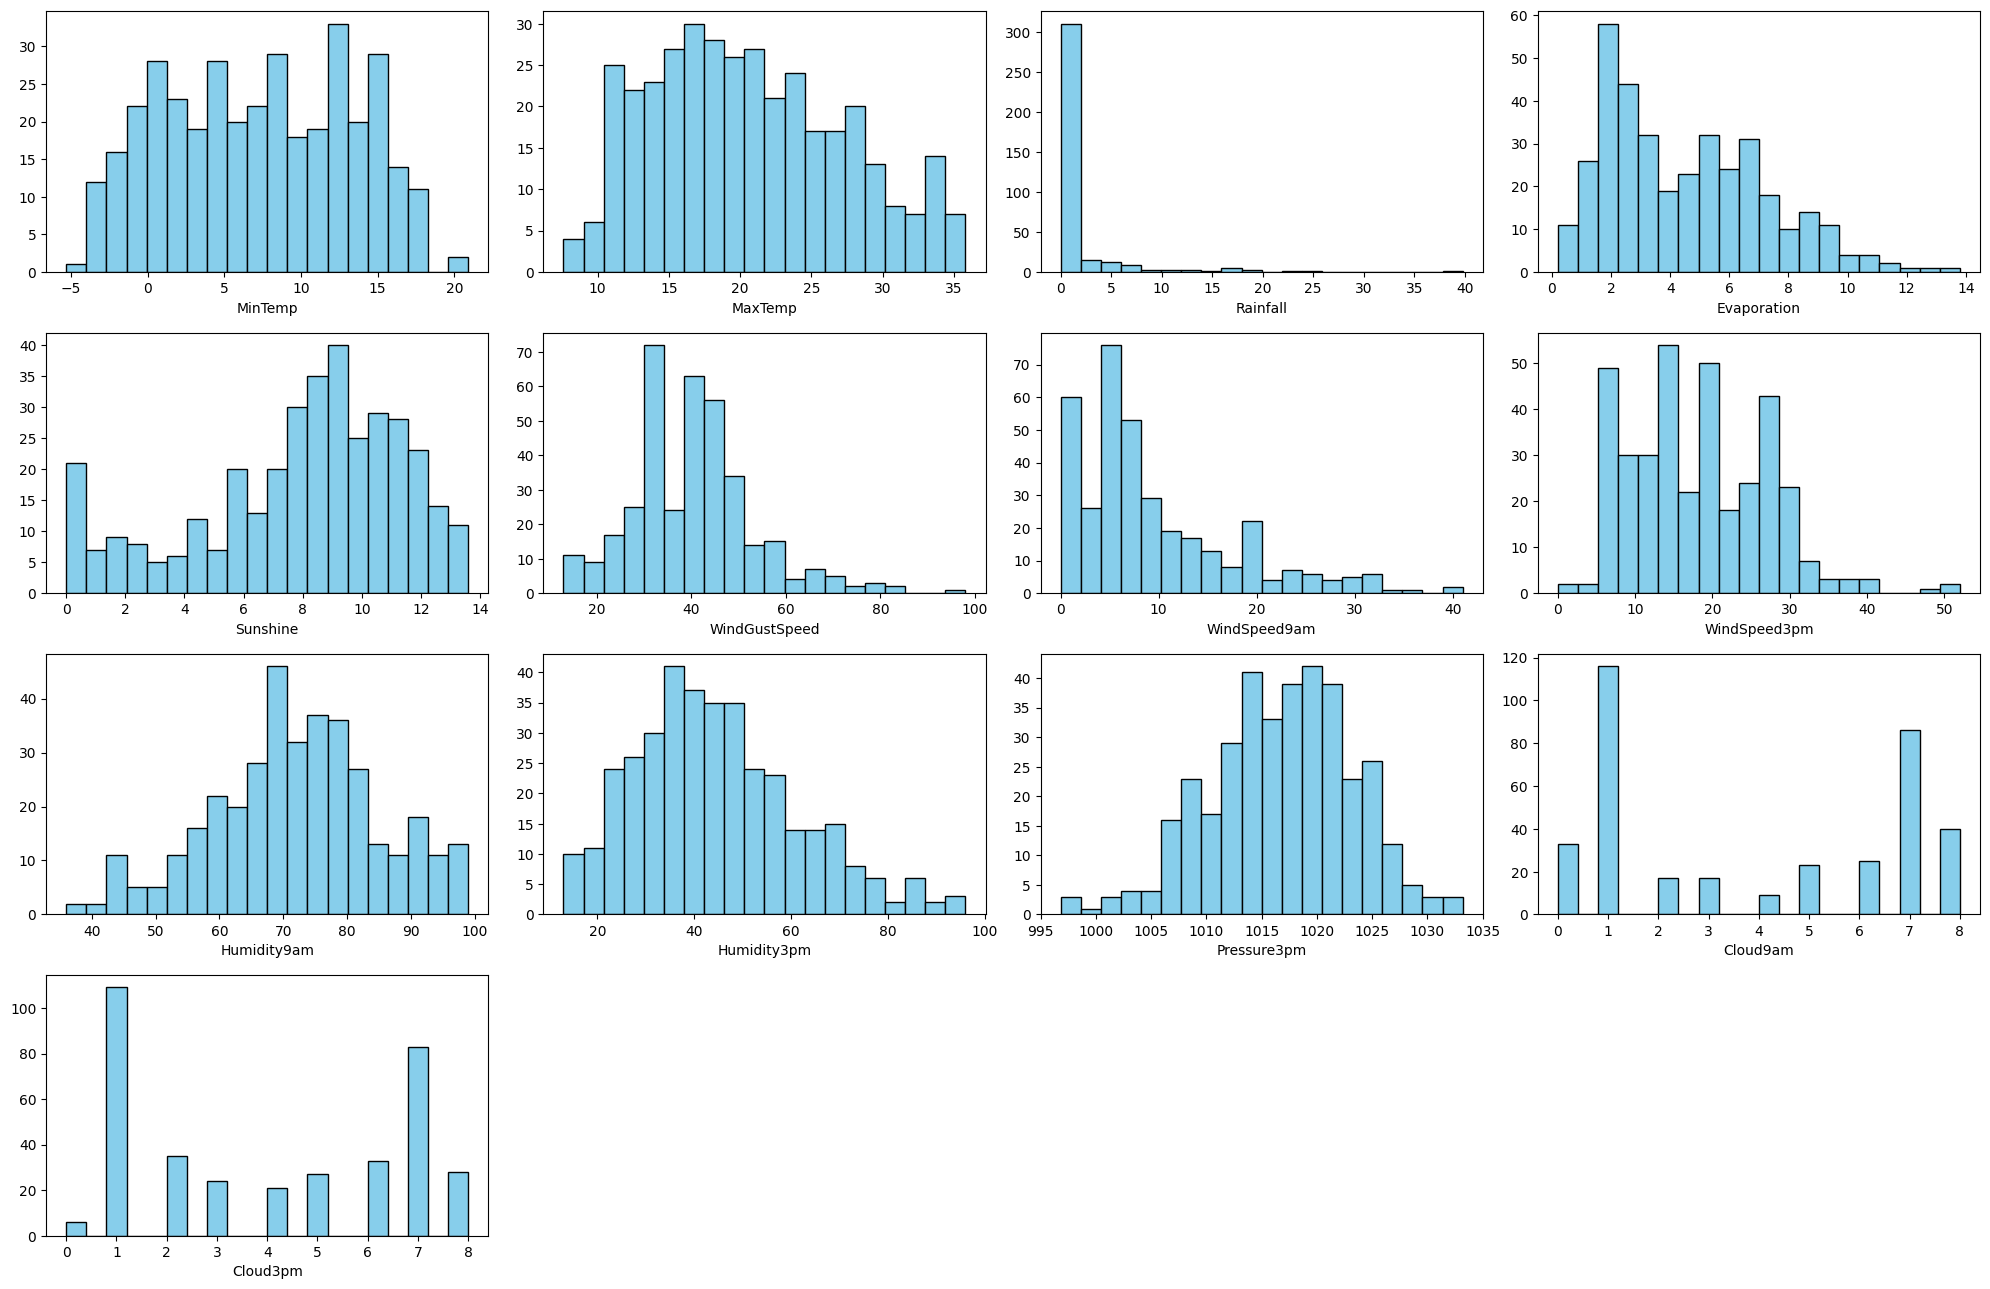

In [89]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 13))

axes = axes.flatten()
columns = ['MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine','WindGustSpeed',
           'WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm',
           'Pressure3pm','Cloud9am','Cloud3pm']
for i,column in enumerate(columns):
  ax = axes[i]
  ax.hist(df[column], bins=20, color='skyblue', edgecolor='black')
  ax.set_xlabel(column)

fig.delaxes(axes[13])
fig.delaxes(axes[14])
fig.delaxes(axes[15])


plt.tight_layout()

plt.show()

Wnioski:
- Widzimy, że w przypaku zmiennej Rainfall, najczęstszą wartością jest liczba 0. Dzieje się tak z racji na małą ilośc danych odnośnie dni deszczowych (co zauważyliśmy już przy okazji omawiania zmiennej RainTomorrow).
- Zmienne mają bardzo różne zakresy, dla przykładu Pressure3pm ma zakres 995-1035, a zmienna Cloud3pm 0-8. Wskazuje to na potrzebę normalizacji, o czym później.
- Widzimy że zachmurzenie utrzymuje się zwykle na poziomie 1 (bardzo słabe zachmurzenie) oraz 7 (duże zachmurzenie).

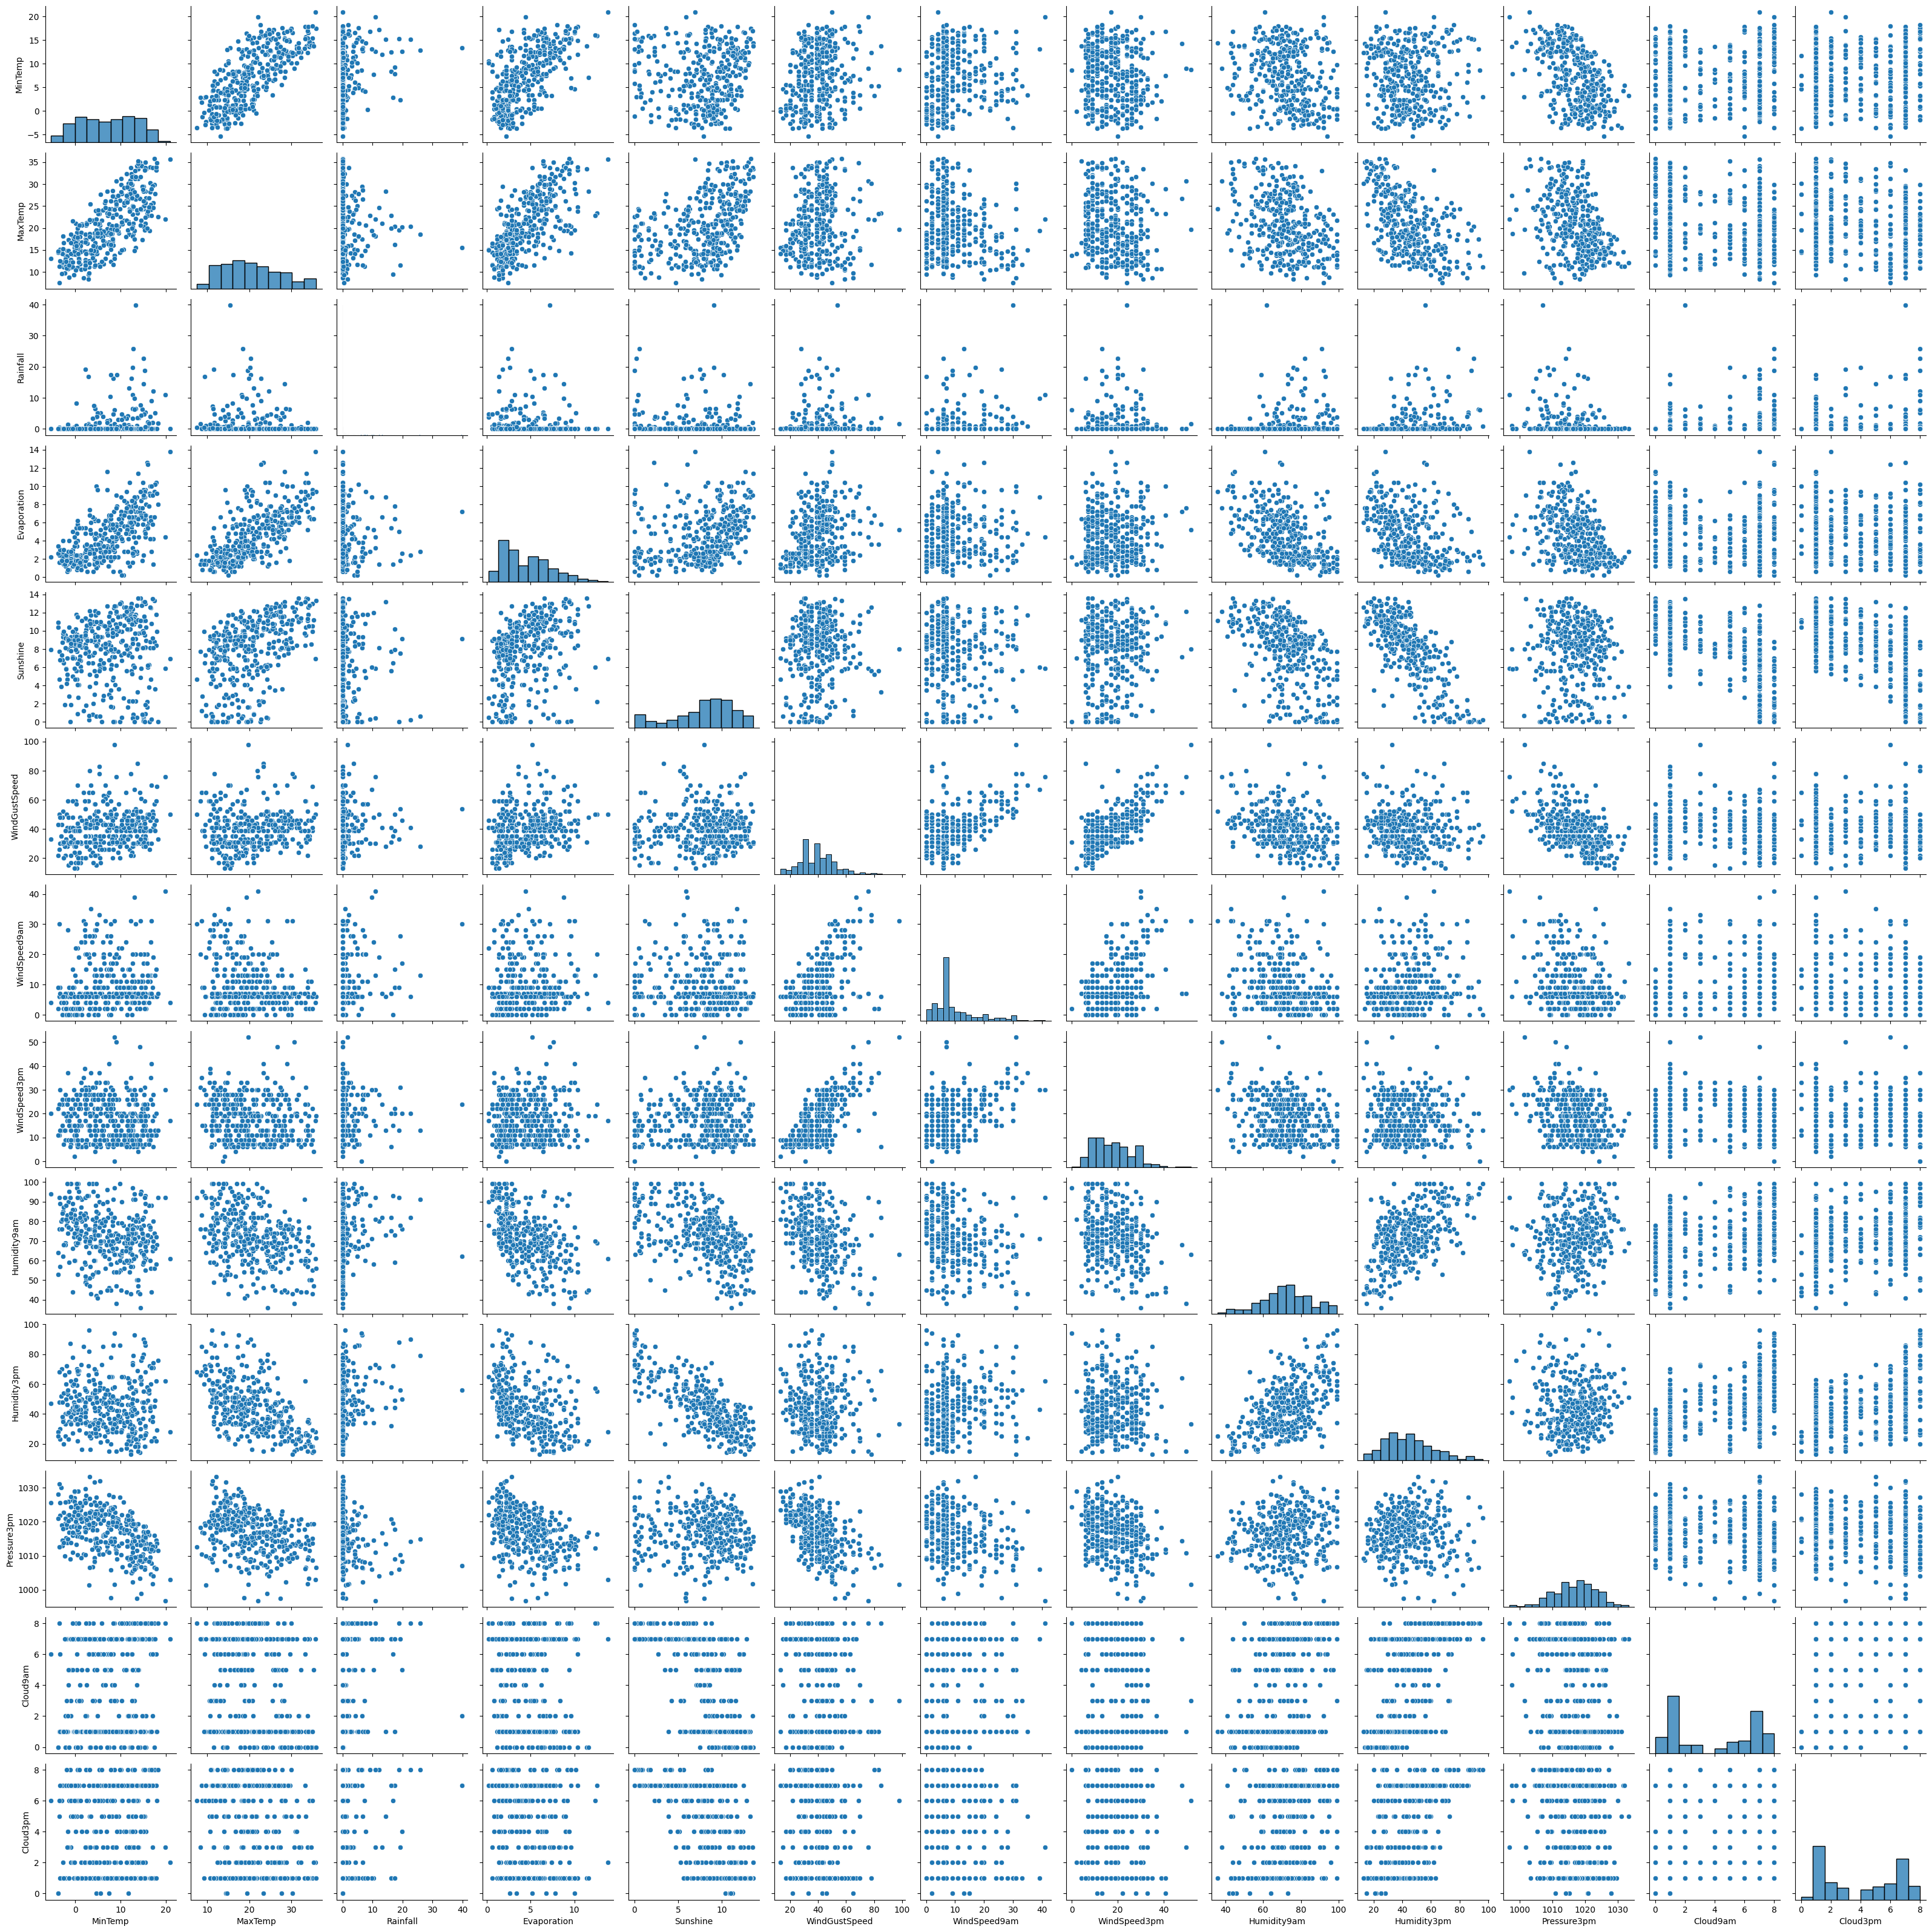

In [90]:
sns.pairplot(df)

Na koniec zerknijmy jeszcze na opisy poszczególnych kolumn zawierające przydatne dla nas informacje, takie jak średnie, wartości minimalne i maksymalne, percentyle etc.:

In [91]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm
count,366.000000,366.000000,366.000000,366.000000,363.000000,364.000000,359.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,7.265574,20.550273,1.428415,4.521858,7.909366,39.840659,9.651811,17.986339,72.035519,44.519126,1016.810383,3.890710,4.024590
std,6.025800,6.690516,4.225800,2.669383,3.481517,13.059807,7.951929,8.856997,13.137058,16.850947,6.469422,2.956131,2.666268
min,-5.300000,7.600000,0.000000,0.200000,0.000000,13.000000,0.000000,0.000000,36.000000,13.000000,996.800000,0.000000,0.000000
25%,2.300000,15.025000,0.000000,2.200000,5.950000,31.000000,6.000000,11.000000,64.000000,32.250000,1012.800000,1.000000,1.000000
50%,7.450000,19.650000,0.000000,4.200000,8.600000,39.000000,7.000000,17.000000,72.000000,43.000000,1017.400000,3.500000,4.000000
75%,12.500000,25.500000,0.200000,6.400000,10.500000,46.000000,13.000000,24.000000,81.000000,55.000000,1021.475000,7.000000,7.000000
max,20.900000,35.800000,39.800000,13.800000,13.600000,98.000000,41.000000,52.000000,99.000000,96.000000,1033.200000,8.000000,8.000000


Tutaj natomiast widzimy:
- Najniższa zanotowana temperatura wynosi $-5,3^∘$.
- Najwyższa zanotowana temperatura wynosi $35,8^∘$.
- Średnia najwyższa temperatura to $20,5^\circ$.

In [92]:
df.describe(include='O')

,WindGustDir,WindDir9am,WindDir3pm,RainTomorrow
count,363,335,365,366
unique,16,16,16,2
top,NW,SE,NW,No
freq,73,47,61,300


Tu potwierdzenie wniosków które wysnuliśmy na podstawie wykresów.

## Wartości NaN

Teraz przyjrzymy się dokładniej wartościom `NaN`, o których dowiedzieliśmy się wcześniej:

In [93]:
df.isnull().sum()

MinTemp           0
MaxTemp           0
Rainfall          0
Evaporation       0
Sunshine          3
WindGustDir       3
WindGustSpeed     2
WindDir9am       31
WindDir3pm        1
WindSpeed9am      7
WindSpeed3pm      0
Humidity9am       0
Humidity3pm       0
Pressure3pm       0
Cloud9am          0
Cloud3pm          0
RainTomorrow      0
dtype: int64

Nie ma ich co prawda dużo, ale dalej lepiej jest je uzupełnić, niż po prostu usunąć.

Aby to zrobić, użyjemy dwóch instancji `SimpleImputer`, gdzie jedna odpowiadać będzie za uzupełnianie kolumn numerycznych średnią z całej kolumny, a druga uzupełni kolumny kategoryczne najczęściej występującymi wartościami.

W celu połączenia dwóch operacji użyjemy `ColumnTransformer`, gdzie w prosty sposób zaznaczamy które instancje, na których kolumnach chcemy wykorzystać. słowo `passthrough` wskazuje na ominięcie danej kolumny.

Oprócz tego, by zachować typy naszych kolumn należy w odpowiedni sposób ustawić wyjście naszej instancji `ColumnTransformer`.

In [94]:

impute_num = SimpleImputer(missing_values=np.nan, strategy='mean')
impute_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
column_t = ColumnTransformer([('pass', 'passthrough', slice(0,4)),
                              ('impute_num1', impute_num, [4]),
                              ('impute_cat1', impute_cat, [5]),
                              ('impute_num2', impute_num, [6]),
                              ('impute_cat2', impute_cat, [7,8]),
                              ('impute_num3', impute_num, [9]),
                              ('pass2', 'passthrough', slice(10,20))],
                              verbose_feature_names_out=False)

column_t.set_output(transform="pandas")
df = pd.DataFrame(column_t.fit_transform(df),columns=column_t.get_feature_names_out())

Sprawdźmy, czy na pewno wszystkie wartości `NaN` zostały uzupełnione:

In [95]:
df.isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
RainTomorrow     0
dtype: int64

Jak widać, udało się.

## Normalizacja

Na wcześniejszych histogramach widzieliśmy, jak różne zakresy mają różne kolumny w naszym zbiorze. Dla przykładu weźmy sobie kolumnę "MaxTemp" oraz "Preassure5pm":

<Axes: >

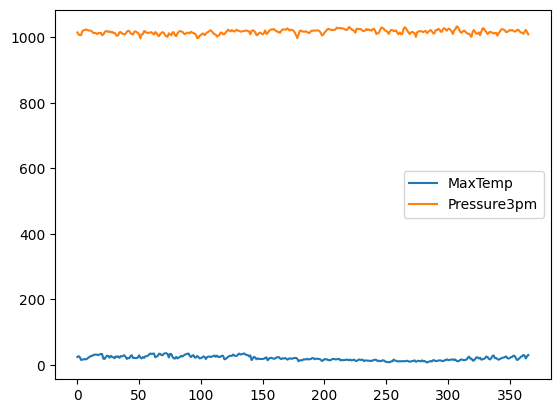

In [96]:
df.plot(y=['MaxTemp','Pressure3pm'])

Teraz jeszcze bardziej naoczna jest ogromna różnica, którą należy zniwelować. W tym celu użyjemy `MinMaxScaler`, który zawęzi zakres wszystkich kolumn numerycznych do 0-1:

In [97]:
from sklearn.preprocessing import MinMaxScaler

X = df.select_dtypes(np.number)
df[X.columns] = MinMaxScaler().fit_transform(X)
df

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainTomorrow
0,0.507634,0.592199,0.000000,0.235294,0.463235,NW,0.200000,SW,NW,0.146341,0.384615,0.507937,0.192771,0.500000,0.875,0.875,Yes
1,0.736641,0.684397,0.090452,0.308824,0.713235,ENE,0.305882,E,W,0.097561,0.326923,0.698413,0.277108,0.318681,0.625,0.375,Yes
2,0.725191,0.560284,0.090452,0.411765,0.242647,NW,0.847059,N,NNE,0.146341,0.115385,0.730159,0.674699,0.285714,1.000,0.875,Yes
3,0.709924,0.280142,1.000000,0.514706,0.669118,NW,0.482353,WNW,W,0.731707,0.461538,0.412698,0.518072,0.280220,0.250,0.875,Yes
4,0.492366,0.301418,0.070352,0.397059,0.779412,SSE,0.435294,SSE,ESE,0.487805,0.538462,0.507937,0.433735,0.596154,0.875,0.875,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.545802,0.819149,0.000000,0.544118,0.889706,NNW,0.741176,SSE,NW,0.170732,0.961538,0.031746,0.024096,0.384615,0.125,0.375,No
362,0.473282,0.737589,0.000000,0.838235,0.933824,N,0.411765,NNW,NNW,0.048780,0.365385,0.142857,0.108434,0.552198,0.000,0.125,No
363,0.679389,0.436170,0.000000,0.602941,0.389706,ESE,0.352941,ENE,ENE,0.268293,0.173077,0.428571,0.409639,0.714286,0.375,0.250,No
364,0.679389,0.684397,0.000000,0.352941,0.522059,NW,0.388235,SSW,WNW,0.146341,0.538462,0.523810,0.313253,0.532967,0.750,0.875,No


Po zamianie nasz wcześniejszy wykres wygląda tak:

<Axes: >

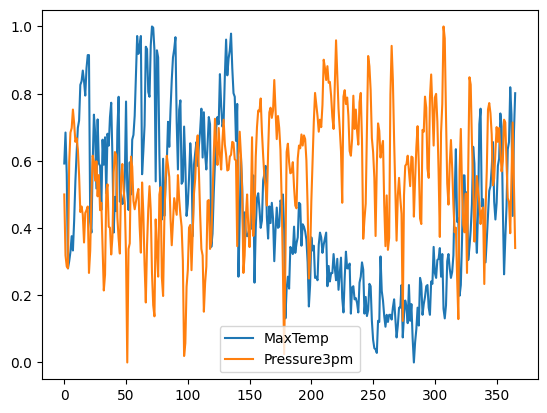

In [98]:
df.plot(y=['MaxTemp','Pressure3pm'])

Teraz możemy spokojnie wyciągać wnioski z niniejszego wykresu. Widzimy, jak niższe temperatury wywołują wyższe ciśnienie, a niższe je podwyższają.

### One-Hot encoding
Aby nie musieć przejmować się istnieniem w naszym zbiorze zmiennych kategorycznych, zastosujemy tzw. "one-hot encoding", który pozwoli zamienić je na wartości ciągłe. Funkcja `get_dummies` pozwala na zastosowanie tej metody dla wybranych kolumn w naszym zbiorze.

Zmienną kategoryczną jest również nasza zmienna celu (wartości "TAK", lub "NIE"), Jest to podział binarny, dlatego łatwo będzie zmienić ją na zmienną ciągłą z pomocą `LabelEncoder`.

Przy okazji od razu wyłuskamy zbiór **y**:



In [99]:
le = LabelEncoder()
df["RainTomorrow"] = le.fit_transform(df["RainTomorrow"])
df

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainTomorrow
0,0.507634,0.592199,0.000000,0.235294,0.463235,NW,0.200000,SW,NW,0.146341,0.384615,0.507937,0.192771,0.500000,0.875,0.875,1
1,0.736641,0.684397,0.090452,0.308824,0.713235,ENE,0.305882,E,W,0.097561,0.326923,0.698413,0.277108,0.318681,0.625,0.375,1
2,0.725191,0.560284,0.090452,0.411765,0.242647,NW,0.847059,N,NNE,0.146341,0.115385,0.730159,0.674699,0.285714,1.000,0.875,1
3,0.709924,0.280142,1.000000,0.514706,0.669118,NW,0.482353,WNW,W,0.731707,0.461538,0.412698,0.518072,0.280220,0.250,0.875,1
4,0.492366,0.301418,0.070352,0.397059,0.779412,SSE,0.435294,SSE,ESE,0.487805,0.538462,0.507937,0.433735,0.596154,0.875,0.875,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.545802,0.819149,0.000000,0.544118,0.889706,NNW,0.741176,SSE,NW,0.170732,0.961538,0.031746,0.024096,0.384615,0.125,0.375,0
362,0.473282,0.737589,0.000000,0.838235,0.933824,N,0.411765,NNW,NNW,0.048780,0.365385,0.142857,0.108434,0.552198,0.000,0.125,0
363,0.679389,0.436170,0.000000,0.602941,0.389706,ESE,0.352941,ENE,ENE,0.268293,0.173077,0.428571,0.409639,0.714286,0.375,0.250,0
364,0.679389,0.684397,0.000000,0.352941,0.522059,NW,0.388235,SSW,WNW,0.146341,0.538462,0.523810,0.313253,0.532967,0.750,0.875,0


In [100]:
df = pd.get_dummies(df, columns=['WindGustDir','WindDir9am','WindDir3pm'])
df

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,0.507634,0.592199,0.000000,0.235294,0.463235,0.200000,0.146341,0.384615,0.507937,0.192771,...,0,1,0,0,0,0,0,0,0,0
1,0.736641,0.684397,0.090452,0.308824,0.713235,0.305882,0.097561,0.326923,0.698413,0.277108,...,0,0,0,0,0,0,0,1,0,0
2,0.725191,0.560284,0.090452,0.411765,0.242647,0.847059,0.146341,0.115385,0.730159,0.674699,...,0,0,0,0,0,0,0,0,0,0
3,0.709924,0.280142,1.000000,0.514706,0.669118,0.482353,0.731707,0.461538,0.412698,0.518072,...,0,0,0,0,0,0,0,1,0,0
4,0.492366,0.301418,0.070352,0.397059,0.779412,0.435294,0.487805,0.538462,0.507937,0.433735,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.545802,0.819149,0.000000,0.544118,0.889706,0.741176,0.170732,0.961538,0.031746,0.024096,...,0,1,0,0,0,0,0,0,0,0
362,0.473282,0.737589,0.000000,0.838235,0.933824,0.411765,0.048780,0.365385,0.142857,0.108434,...,1,0,0,0,0,0,0,0,0,0
363,0.679389,0.436170,0.000000,0.602941,0.389706,0.352941,0.268293,0.173077,0.428571,0.409639,...,0,0,0,0,0,0,0,0,0,0
364,0.679389,0.684397,0.000000,0.352941,0.522059,0.388235,0.146341,0.538462,0.523810,0.313253,...,0,0,0,0,0,0,0,0,1,0


# Tworzenie zbiorów testowych oraz treningowych


Na początku zajmijmy się stworzeniem naszego zbioru **y**, w tym cełu musimy wyłuskać z naszego zbioru danych kolumnę "RainTomorrow":

In [101]:
y = df["RainTomorrow"]
y

0      1
1      1
2      1
3      1
4      0
      ..
361    0
362    0
363    0
364    0
365    0
Name: RainTomorrow, Length: 366, dtype: int64

Teraz wystarczy wyrzucić z df niepotrzebną kolumnę 'RainTomorrow', aby uzyskać nasz zbiór X:

In [102]:
X = df.drop(columns=['RainTomorrow'])
X

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,0.507634,0.592199,0.000000,0.235294,0.463235,0.200000,0.146341,0.384615,0.507937,0.192771,...,0,1,0,0,0,0,0,0,0,0
1,0.736641,0.684397,0.090452,0.308824,0.713235,0.305882,0.097561,0.326923,0.698413,0.277108,...,0,0,0,0,0,0,0,1,0,0
2,0.725191,0.560284,0.090452,0.411765,0.242647,0.847059,0.146341,0.115385,0.730159,0.674699,...,0,0,0,0,0,0,0,0,0,0
3,0.709924,0.280142,1.000000,0.514706,0.669118,0.482353,0.731707,0.461538,0.412698,0.518072,...,0,0,0,0,0,0,0,1,0,0
4,0.492366,0.301418,0.070352,0.397059,0.779412,0.435294,0.487805,0.538462,0.507937,0.433735,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.545802,0.819149,0.000000,0.544118,0.889706,0.741176,0.170732,0.961538,0.031746,0.024096,...,0,1,0,0,0,0,0,0,0,0
362,0.473282,0.737589,0.000000,0.838235,0.933824,0.411765,0.048780,0.365385,0.142857,0.108434,...,1,0,0,0,0,0,0,0,0,0
363,0.679389,0.436170,0.000000,0.602941,0.389706,0.352941,0.268293,0.173077,0.428571,0.409639,...,0,0,0,0,0,0,0,0,0,0
364,0.679389,0.684397,0.000000,0.352941,0.522059,0.388235,0.146341,0.538462,0.523810,0.313253,...,0,0,0,0,0,0,0,0,1,0


Mamy już odzielne zbiory **X** oraz **y**, ostatnie co nam zostało to podzielenie wszystkiego na zbiory treningowe oraz testowe przy użyciu `train_test_split`:

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Klasyfikowanie

Teraz czas na sprawdzenie jak ze zbiorem poradzą sobie różne klasyfikatory, aby nie powtarzać się przy każdym z osobna, teraz omówimy jakie metryki będą opisywane.

Dla każdego modelu, sprawdzać będziemy takie metryki jak dokładność, precyzja, wynik-F1 itp. Posłuży nam do tego bardzo przydatna funkcja `classification_report`, która daje nam te informacje w czytelnym formacie.

Oprócz tego sporządzimy odpowiednie macierze pomyłek dla zbioru treningowego oraz testowego, a poza tym wykresy ROC.

In [104]:
metrics = {"accuracy":[], "precision":[], "recall":[], "f1-score":[]}

## Perceptron

Na początek zaczniemy od zwykłego perceptrona

In [105]:
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train, y_train)

Perceptron(eta0=0.1, random_state=1)

In [106]:
y_pred_train = ppn.predict(X_train)
y_pred_test = ppn.predict(X_test)

In [107]:
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test))
metrics["precision"].append(precision_score(y_test, y_pred_test))
metrics["recall"].append(recall_score(y_test, y_pred_test))
metrics["f1-score"].append(f1_score(y_test, y_pred_test))

In [108]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82        90
           1       0.35      0.60      0.44        20

    accuracy                           0.73       110
   macro avg       0.62      0.68      0.63       110
weighted avg       0.80      0.73      0.75       110



In [109]:
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)
cm_train, cm_test

(array([[160,  50],
        [  4,  42]]),
 array([[68, 22],
        [ 8, 12]]))

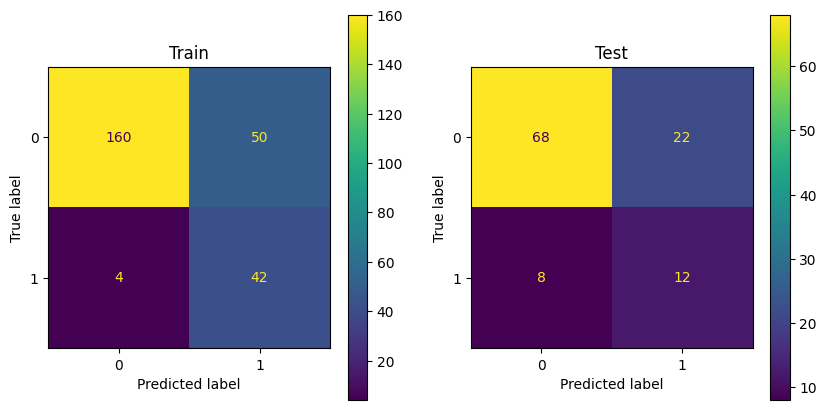

In [110]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

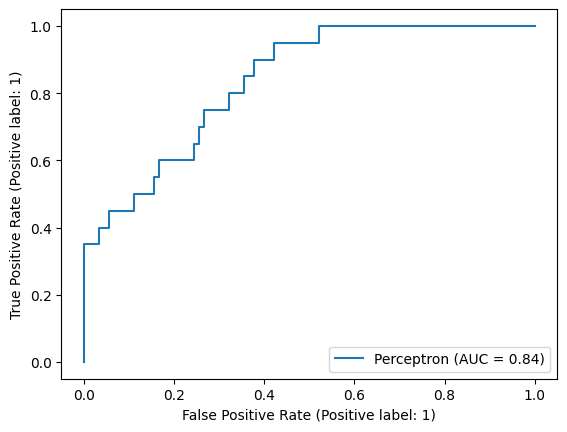

In [111]:
RocCurveDisplay.from_estimator(ppn,X_test,y_test)

## SGDClassifier


In [112]:
sgd = SGDClassifier(loss="log_loss").fit(X_train,y_train)

In [113]:
y_pred_train_sgd = sgd.predict(X_train)
y_pred_train_sgd

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [114]:
y_pred_test_sgd = sgd.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_sgd))
metrics["precision"].append(precision_score(y_test, y_pred_test_sgd))
metrics["recall"].append(recall_score(y_test, y_pred_test_sgd))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_sgd))

In [115]:
print(classification_report(y_test,y_pred_test_sgd))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92        90
           1       0.83      0.25      0.38        20

    accuracy                           0.85       110
   macro avg       0.84      0.62      0.65       110
weighted avg       0.85      0.85      0.82       110



In [116]:
cm_train = confusion_matrix(y_train, y_pred_train_sgd)
cm_test = confusion_matrix(y_test, y_pred_test_sgd)
cm_train, cm_test

(array([[209,   1],
        [ 26,  20]]),
 array([[89,  1],
        [15,  5]]))

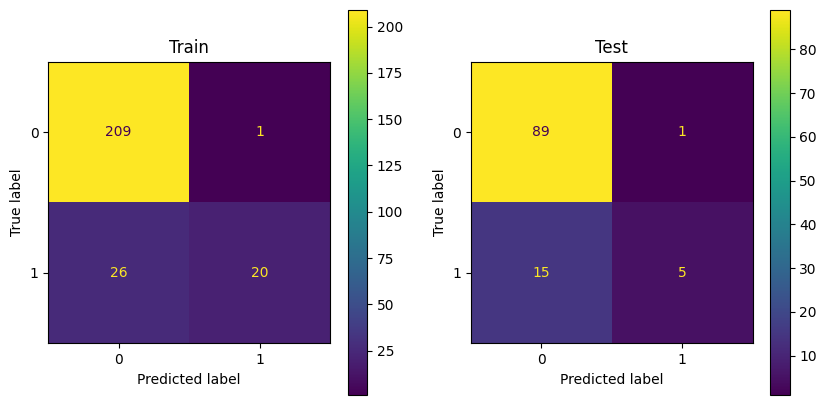

In [117]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

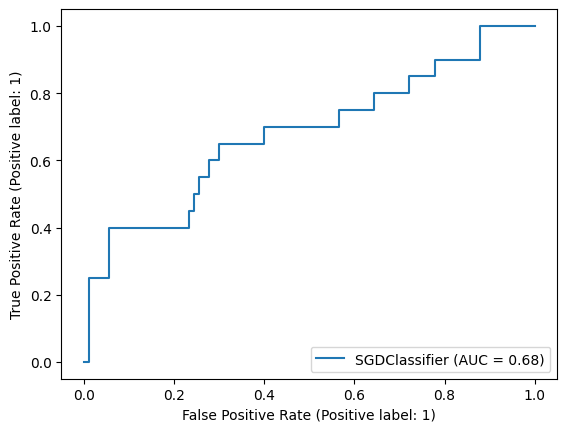

In [118]:
RocCurveDisplay.from_estimator(sgd,X_test,y_test)

## DecisionTreeClassifier


[Text(0.5217391304347826, 0.9, 'x[4] <= 0.474\ngini = 0.295\nsamples = 256\nvalue = [210, 46]'),
 Text(0.2391304347826087, 0.7, 'x[10] <= 0.53\ngini = 0.486\nsamples = 72\nvalue = [42, 30]'),
 Text(0.13043478260869565, 0.5, 'x[13] <= 0.5\ngini = 0.383\nsamples = 31\nvalue = [8, 23]'),
 Text(0.08695652173913043, 0.3, 'x[0] <= 0.594\ngini = 0.328\nsamples = 29\nvalue = [6, 23]'),
 Text(0.043478260869565216, 0.1, 'gini = 0.473\nsamples = 13\nvalue = [5, 8]'),
 Text(0.13043478260869565, 0.1, 'gini = 0.117\nsamples = 16\nvalue = [1, 15]'),
 Text(0.17391304347826086, 0.3, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.34782608695652173, 0.5, 'x[7] <= 0.125\ngini = 0.283\nsamples = 41\nvalue = [34, 7]'),
 Text(0.2608695652173913, 0.3, 'x[39] <= 0.5\ngini = 0.375\nsamples = 4\nvalue = [1, 3]'),
 Text(0.21739130434782608, 0.1, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.30434782608695654, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.43478260869565216, 0.3, 'x[21] <= 0.5

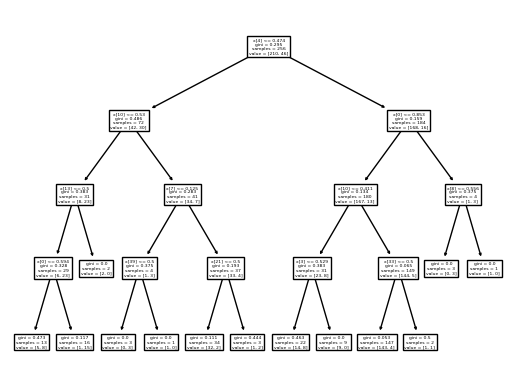

In [119]:
DTC = DecisionTreeClassifier(max_depth=4).fit(X_train,y_train)
plot_tree(DTC)

In [120]:
y_pred_train_DTC = DTC.predict(X_train)
y_pred_train_DTC

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [121]:
y_pred_test_DTC = DTC.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_DTC))
metrics["precision"].append(precision_score(y_test, y_pred_test_DTC))
metrics["recall"].append(recall_score(y_test, y_pred_test_DTC))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_DTC))

In [122]:
print(classification_report(y_test,y_pred_test_DTC))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91        90
           1       0.57      0.60      0.59        20

    accuracy                           0.85       110
   macro avg       0.74      0.75      0.75       110
weighted avg       0.85      0.85      0.85       110



In [123]:
cm_train = confusion_matrix(y_train, y_pred_train_DTC)
cm_test = confusion_matrix(y_test, y_pred_test_DTC)
cm_train, cm_test

(array([[203,   7],
        [ 15,  31]]),
 array([[81,  9],
        [ 8, 12]]))

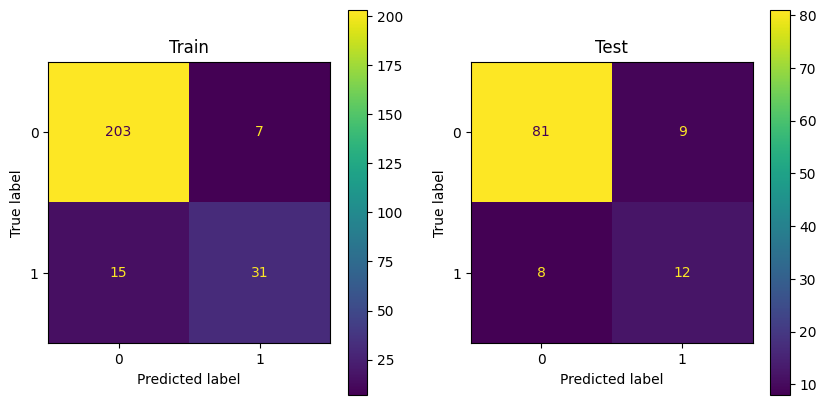

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

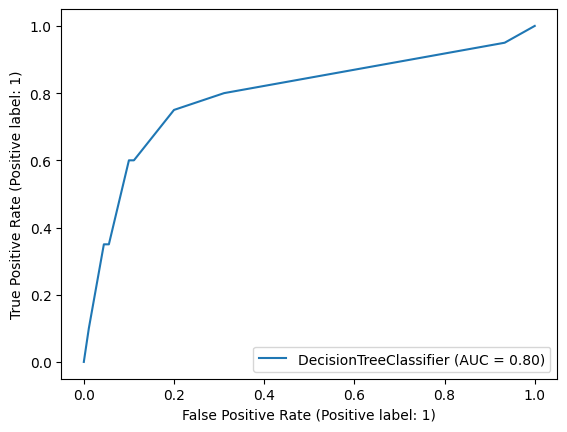

In [125]:
RocCurveDisplay.from_estimator(DTC,X_test,y_test)

## LogisticRegresion

In [126]:
lr = LogisticRegression().fit(X_train,y_train)

In [127]:
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_lr))
metrics["precision"].append(precision_score(y_test, y_pred_test_lr))
metrics["recall"].append(recall_score(y_test, y_pred_test_lr))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_lr))

In [128]:
print(classification_report(y_test,y_pred_test_lr))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93        90
           1       0.88      0.35      0.50        20

    accuracy                           0.87       110
   macro avg       0.87      0.67      0.71       110
weighted avg       0.87      0.87      0.85       110



In [129]:
cm_train = confusion_matrix(y_train, y_pred_train_lr)
cm_test = confusion_matrix(y_test, y_pred_test_lr)
cm_train, cm_test

(array([[207,   3],
        [ 20,  26]]),
 array([[89,  1],
        [13,  7]]))

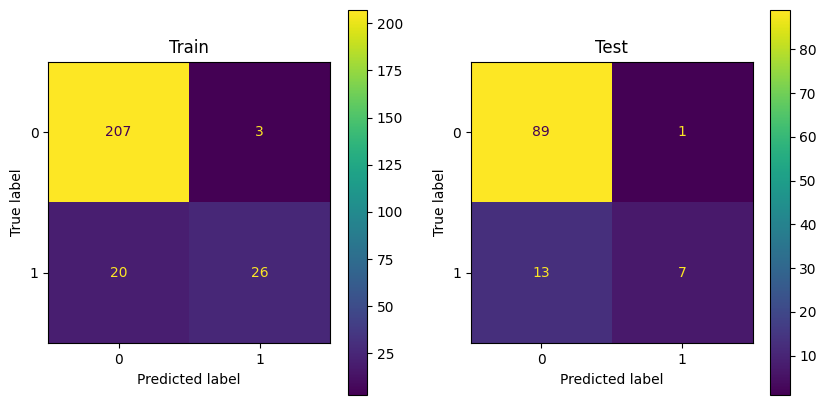

In [130]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

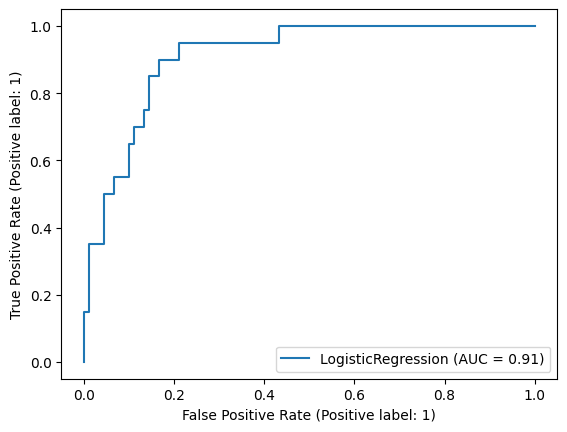

In [131]:
RocCurveDisplay.from_estimator(lr,X_test,y_test)

## KNeighborsClassifier

In [132]:
kn = KNeighborsClassifier().fit(X_train,y_train)

In [133]:
y_pred_train_kn = kn.predict(X_train)
y_pred_test_kn = kn.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_kn))
metrics["precision"].append(precision_score(y_test, y_pred_test_kn))
metrics["recall"].append(recall_score(y_test, y_pred_test_kn))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_kn))

In [134]:
print(classification_report(y_test,y_pred_test_kn))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90        90
           1       0.50      0.10      0.17        20

    accuracy                           0.82       110
   macro avg       0.67      0.54      0.53       110
weighted avg       0.77      0.82      0.76       110



In [135]:
cm_train = confusion_matrix(y_train, y_pred_train_kn)
cm_test = confusion_matrix(y_test, y_pred_test_kn)
cm_train, cm_test

(array([[208,   2],
        [ 29,  17]]),
 array([[88,  2],
        [18,  2]]))

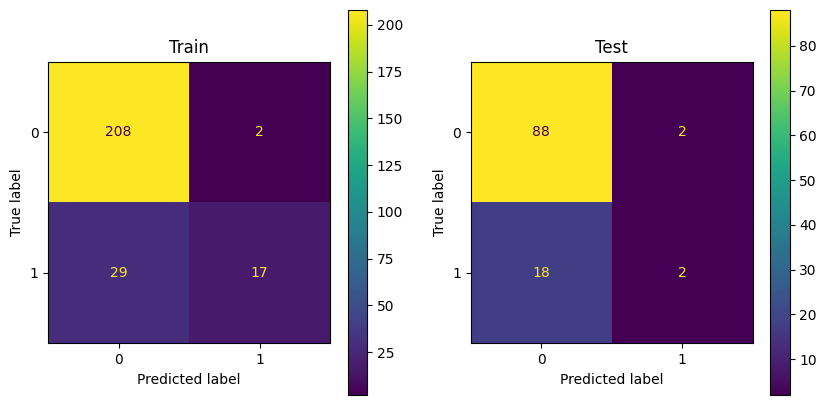

In [136]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

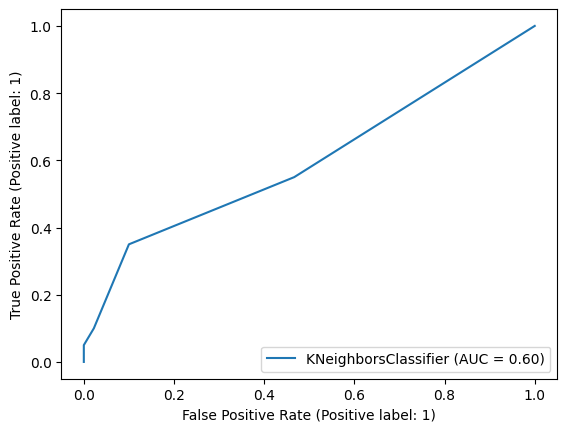

In [137]:
RocCurveDisplay.from_estimator(kn,X_test,y_test)

## RandomForestClassifier


In [138]:
rfc = RandomForestClassifier().fit(X_train,y_train)

In [139]:
y_pred_train_rfc = rfc.predict(X_train)
y_pred_test_rfc = rfc.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_rfc))
metrics["precision"].append(precision_score(y_test, y_pred_test_rfc))
metrics["recall"].append(recall_score(y_test, y_pred_test_rfc))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_rfc))

In [140]:
print(classification_report(y_test,y_pred_test_rfc))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94        90
           1       0.91      0.50      0.65        20

    accuracy                           0.90       110
   macro avg       0.90      0.74      0.79       110
weighted avg       0.90      0.90      0.89       110



In [141]:
cm_train = confusion_matrix(y_train, y_pred_train_rfc)
cm_test = confusion_matrix(y_test, y_pred_test_rfc)
cm_train, cm_test

(array([[210,   0],
        [  0,  46]]),
 array([[89,  1],
        [10, 10]]))

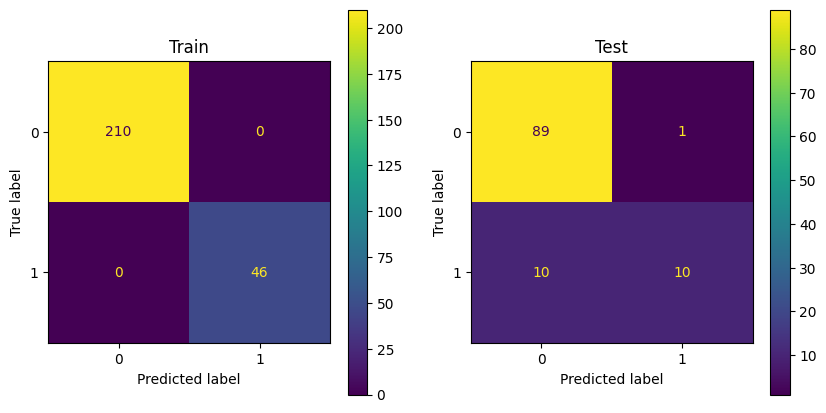

In [142]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

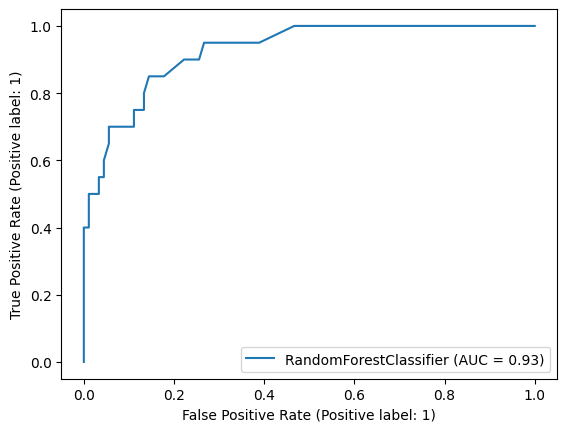

In [143]:
RocCurveDisplay.from_estimator(rfc,X_test,y_test)

## SVC

In [144]:
svc = SVC().fit(X_train,y_train)

In [145]:
y_pred_train_svc = svc.predict(X_train)
y_pred_test_svc = svc.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_svc))
metrics["precision"].append(precision_score(y_test, y_pred_test_svc))
metrics["recall"].append(recall_score(y_test, y_pred_test_svc))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_svc))

In [146]:
print(classification_report(y_test,y_pred_test_svc))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        90
           1       1.00      0.10      0.18        20

    accuracy                           0.84       110
   macro avg       0.92      0.55      0.55       110
weighted avg       0.86      0.84      0.78       110



In [147]:
cm_train = confusion_matrix(y_train, y_pred_train_svc)
cm_test = confusion_matrix(y_test, y_pred_test_svc)
cm_train, cm_test

(array([[210,   0],
        [ 27,  19]]),
 array([[90,  0],
        [18,  2]]))

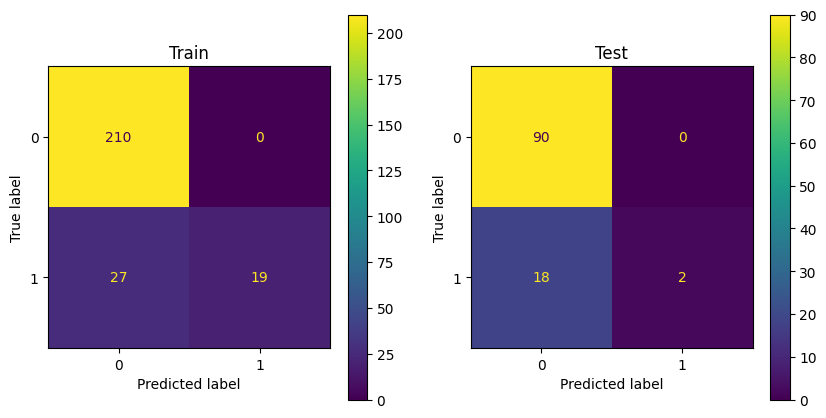

In [148]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("Train")
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[1].set_title("Test")
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])

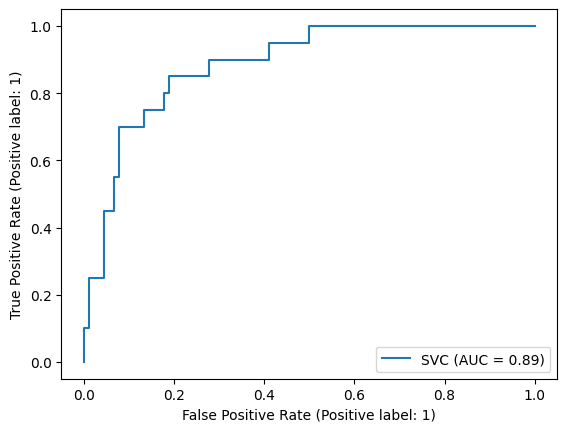

In [149]:
RocCurveDisplay.from_estimator(svc,X_test,y_test)

## Podsumowanie


Zobaczmy teraz zestawienie metryk dla wszystkich modeli:

In [150]:
summary = pd.DataFrame(data=metrics,index=["Perceptron","SGD","DecisionTreeClassifier","LogisticRegression","KNeighboursClassifier","RandomForestClassifier","SVC"])
summary

,accuracy,precision,recall,f1-score
Perceptron,0.727273,0.352941,0.60,0.444444
SGD,0.854545,0.833333,0.25,0.384615
DecisionTreeClassifier,0.845455,0.571429,0.60,0.585366
LogisticRegression,0.872727,0.875000,0.35,0.500000
KNeighboursClassifier,0.818182,0.500000,0.10,0.166667
RandomForestClassifier,0.900000,0.909091,0.50,0.645161
SVC,0.836364,1.000000,0.10,0.181818


A oprócz tego wykres:

<Axes: >

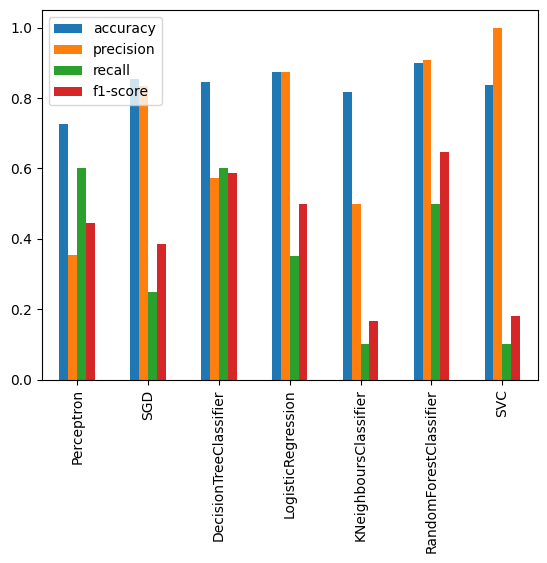

In [151]:
summary.plot.bar()

Biorąc pod uwagę metrykę wyniku f1, na podium uplasowały się modele:
1. RandomForestClassifier
2. DecisionTreeClassifier
3. LogisticRegression

`RandomForestClassifier` oprócz najwyżeszego wyniku f1, charakteryzuje się najwyższą dokładnością (90%), drugą najwyższą precyzją oraz trzecią najlepszą czułością.

# Klasyfikacja druga


Wcześniejsze modele operowały na zbiorze danych, gdzie wartości kolumny **y** nie były zbalansowane. Teraz skorzystamy z możliwości "dorobienia" wartości z mniejszej klasy zbioru celu. Wykorzystamy do tego `RandomOverSampler`:


In [152]:
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
X_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,0.790076,0.929078,0.000000,0.367647,0.816176,0.258824,0.170732,0.288462,0.539683,0.156627,...,0,1,0,0,0,0,0,0,0,0
1,0.290076,0.163121,0.000000,0.191176,0.720588,0.364706,0.487805,0.576923,0.349206,0.337349,...,0,1,0,0,0,0,0,0,0,0
2,0.251908,0.106383,0.000000,0.044118,0.411765,0.388235,0.585366,0.634615,0.619048,0.722892,...,0,0,0,0,0,0,0,0,1,0
3,0.297710,0.471631,0.000000,0.250000,0.779412,0.364706,0.487805,0.500000,0.190476,0.265060,...,0,0,0,0,0,0,0,0,1,0
4,0.809160,0.436170,0.020101,0.397059,0.117647,0.411765,0.414634,0.423077,0.587302,0.542169,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.404580,0.556738,0.000000,0.250000,0.411765,0.823529,0.048780,0.711538,0.857143,0.156627,...,0,1,0,0,0,0,0,0,0,0
416,0.755725,0.588652,0.110553,0.470588,0.433824,0.411765,0.219512,0.326923,0.936508,0.566265,...,0,0,0,0,0,0,0,0,1,0
417,0.614504,0.765957,0.000000,0.602941,0.551471,0.435294,0.235410,0.173077,0.317460,0.253012,...,0,0,0,0,0,0,0,0,0,0
418,0.751908,0.464539,0.190955,0.676471,0.360294,0.235294,0.487805,0.365385,0.920635,0.626506,...,1,0,0,0,0,0,0,0,0,0


In [153]:
metrics = {"accuracy":[], "precision":[], "recall":[], "f1-score":[]}

## Perceptron

In [154]:
ppn = Perceptron(eta0=0.1, random_state=1).fit(X_train,y_train)
y_pred_train = ppn.predict(X_train)
y_pred_test = ppn.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test))
metrics["precision"].append(precision_score(y_test, y_pred_test))
metrics["recall"].append(recall_score(y_test, y_pred_test))
metrics["f1-score"].append(f1_score(y_test, y_pred_test))
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.78      0.83        90
           1       0.38      0.60      0.46        20

    accuracy                           0.75       110
   macro avg       0.64      0.69      0.65       110
weighted avg       0.80      0.75      0.77       110



## SGDClassifier

In [155]:
sgd = SGDClassifier(loss="log_loss").fit(X_train,y_train)
y_pred_train_sgd = sgd.predict(X_train)
y_pred_test_sgd = sgd.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_sgd))
metrics["precision"].append(precision_score(y_test, y_pred_test_sgd))
metrics["recall"].append(recall_score(y_test, y_pred_test_sgd))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_sgd))
print(classification_report(y_test,y_pred_test_sgd))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        90
           1       0.31      0.40      0.35        20

    accuracy                           0.73       110
   macro avg       0.58      0.60      0.59       110
weighted avg       0.76      0.73      0.74       110



## DecisionTreeClassifier

In [156]:
DTC = DecisionTreeClassifier(max_depth=4).fit(X_train,y_train)
y_pred_train_DTC = DTC.predict(X_train)
y_pred_test_DTC = DTC.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_DTC))
metrics["precision"].append(precision_score(y_test, y_pred_test_DTC))
metrics["recall"].append(recall_score(y_test, y_pred_test_DTC))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_DTC))
print(classification_report(y_test,y_pred_test_DTC))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78        90
           1       0.35      0.80      0.48        20

    accuracy                           0.69       110
   macro avg       0.64      0.73      0.63       110
weighted avg       0.83      0.69      0.73       110



## LogisticRegression

In [157]:
lr = LogisticRegression().fit(X_train,y_train)
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_lr))
metrics["precision"].append(precision_score(y_test, y_pred_test_lr))
metrics["recall"].append(recall_score(y_test, y_pred_test_lr))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_lr))
print(classification_report(y_test,y_pred_test_lr))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90        90
           1       0.53      0.50      0.51        20

    accuracy                           0.83       110
   macro avg       0.71      0.70      0.70       110
weighted avg       0.82      0.83      0.83       110



## KNeighborsClassifier

In [158]:
kn = KNeighborsClassifier().fit(X_train,y_train)
y_pred_train_kn = kn.predict(X_train)
y_pred_test_kn = kn.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_kn))
metrics["precision"].append(precision_score(y_test, y_pred_test_kn))
metrics["recall"].append(recall_score(y_test, y_pred_test_kn))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_kn))
print(classification_report(y_test,y_pred_test_kn))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79        90
           1       0.26      0.40      0.31        20

    accuracy                           0.68       110
   macro avg       0.55      0.57      0.55       110
weighted avg       0.74      0.68      0.71       110



## RandomForestClassifier

In [159]:
rfc = RandomForestClassifier().fit(X_train,y_train)
y_pred_train_rfc = rfc.predict(X_train)
y_pred_test_rfc = rfc.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_rfc))
metrics["precision"].append(precision_score(y_test, y_pred_test_rfc))
metrics["recall"].append(recall_score(y_test, y_pred_test_rfc))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_rfc))
print(classification_report(y_test,y_pred_test_rfc))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        90
           1       0.85      0.55      0.67        20

    accuracy                           0.90       110
   macro avg       0.88      0.76      0.80       110
weighted avg       0.90      0.90      0.89       110



## SVC

In [160]:
svc = SVC().fit(X_train,y_train)
y_pred_train_svc = svc.predict(X_train)
y_pred_test_svc = svc.predict(X_test)
metrics["accuracy"].append(accuracy_score(y_test, y_pred_test_svc))
metrics["precision"].append(precision_score(y_test, y_pred_test_svc))
metrics["recall"].append(recall_score(y_test, y_pred_test_svc))
metrics["f1-score"].append(f1_score(y_test, y_pred_test_svc))
print(classification_report(y_test,y_pred_test_svc))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89        90
           1       0.50      0.40      0.44        20

    accuracy                           0.82       110
   macro avg       0.69      0.66      0.67       110
weighted avg       0.80      0.82      0.81       110



## Podsumowanie

In [161]:
summary = pd.DataFrame(data=metrics,index=["Perceptron","SGD","DecisionTreeClassifier","LogisticRegression","KNeighboursClassifier","RandomForestClassifier","SVC"])
summary

,accuracy,precision,recall,f1-score
Perceptron,0.745455,0.375000,0.60,0.461538
SGD,0.727273,0.307692,0.40,0.347826
DecisionTreeClassifier,0.690909,0.347826,0.80,0.484848
LogisticRegression,0.827273,0.526316,0.50,0.512821
KNeighboursClassifier,0.681818,0.258065,0.40,0.313725
RandomForestClassifier,0.900000,0.846154,0.55,0.666667
SVC,0.818182,0.500000,0.40,0.444444


<Axes: >

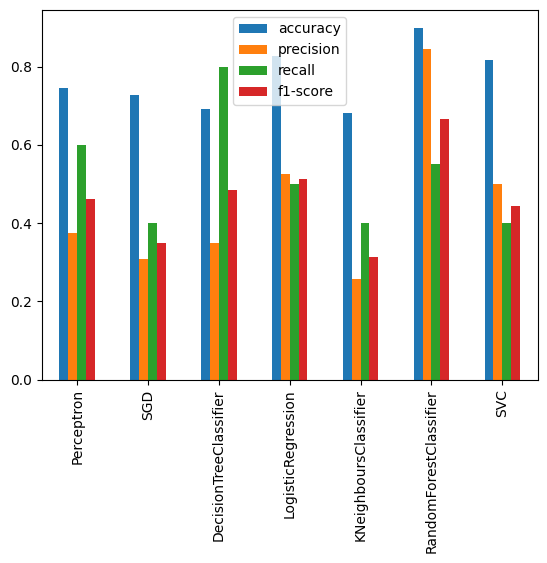

In [162]:
summary.plot.bar()

Widzimy znaczącą poprawę wśród modeli `KNeighborsClassifier` oraz `SVC`, nieznaczną poprawę w `RandomForestClassifier`, `Perceptron` oraz `LogisticRegression`, a także spadek w `SGDClassifier` oraz `DeciosionTreeClassifier`.